In [18]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_images(line):
    """Returns centered, left and right images"""
    result = []
    for i in range(0, 3):
            source = line[i]
            filename = source.split('/')[-1]
            img_path = './data/IMG/%s' % filename
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            result.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            
    return result
    

lines = []
with open ('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

imgs = []
angles = []

for line in lines:
    angle = float(line[3])

    # Center
    center_source = line[0]
    center_fname = center_source.split('/')[-1]
    center_img_path = './data/IMG/%s' % center_fname
    center_img = cv2.imread(center_img_path, cv2.IMREAD_COLOR)
    center_img = cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB)
    center_angle_correction = 0
    imgs.append(center_img)
    angles.append(angle)
    imgs.append(np.fliplr(center_img))
    angles.append(-angle)

    # Left
    left_source = line[1]
    left_fname = left_source.split('/')[-1]
    left_img_path = './data/IMG/%s' % left_fname
    left_img = cv2.imread(left_img_path, cv2.IMREAD_COLOR)
    left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
    left_angle_correction = angle + 0.2
    imgs.append(left_img)
    angles.append(left_angle_correction)
    imgs.append(np.fliplr(left_img))
    angles.append(-left_angle_correction)
    
    # Right
    right_source = line[2]
    right_fname = right_source.split('/')[-1]
    right_img_path = './data/IMG/%s' % right_fname
    right_img = cv2.imread(right_img_path, cv2.IMREAD_COLOR)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
    right_angle_correction = angle - 0.2
    imgs.append(right_img)
    angles.append(right_angle_correction)
    imgs.append(np.fliplr(right_img))
    angles.append(-right_angle_correction)
    

width = imgs[0].shape[1]
height = imgs[0].shape[0]
channels = imgs[0].shape[2]
    

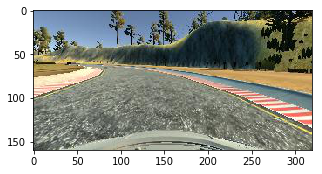

In [19]:
import numpy as np
X_train = np.asarray(imgs)
y_train = np.asarray(angles)

plt.figure(figsize=(5,5))
plt.imshow(X_train[0])

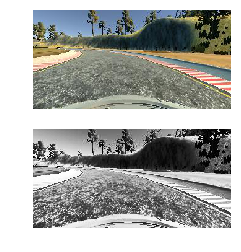

In [20]:
# Play with colors
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist
%matplotlib inline

sample_img = X_train[0]
new_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
new_img = equalize_hist(new_img)


fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)
ax[1].imshow(new_img, cmap='gray')

for a in ax:
    a.axis('off')


In [21]:
from skimage.exposure import equalize_hist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
# Remove the top 50px and bottom 20px, the new image will have shape(90, 320, 3)
model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))

# First layer
model.add(Convolution2D(25, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.summary()

model.add(Convolution2D(50, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.summary()

model.add(Convolution2D(50, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.summary()

model.add(Convolution2D(100, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.summary()

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)

model.save('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_6 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_6[0][0]         
____________________________________________________________________________________________________
convolution2d_21 (Convolution2D) (None, 86, 316, 25)   1900        cropping2d_6[0][0]               
____________________________________________________________________________________________________
activation_29 (Activation)       (None, 86, 316, 25)   0           convolution2d_21[0][0]           
____________________________________________________________________________________________________
maxpooling2d_21 (MaxPooling2D)   (None, 43, 158, 25)   0           activation_29[0][0]              
Total params: 1,900
Trainable params: 1,900
Non-trainable params: 0
_______________________

Train on 5112 samples, validate on 1278 samples
Epoch 1/5
5112/5112 [==============================] - 35s - loss: 25.9904 - val_loss: 0.0518
Epoch 2/5
5112/5112 [==============================] - 35s - loss: 0.0449 - val_loss: 0.0518
Epoch 3/5
5112/5112 [==============================] - 35s - loss: 0.0447 - val_loss: 0.0518
Epoch 4/5
5112/5112 [==============================] - 35s - loss: 0.0441 - val_loss: 0.0518
Epoch 5/5
5112/5112 [==============================] - 35s - loss: 0.0438 - val_loss: 0.0518


In [22]:
model.save('model.h5')